In [2]:
from radd import devtests

In [ ]:
## from radd import fitre, utils, cRADD, build
from scipy.stats.mstats import mquantiles as mq
#!/usr/local/bin/env python
from lmfit import report_fit, fit_report
from __future__ import division
import numpy as np
import pandas as pd
from lmfit import Parameters, Minimizer
from radd.utils import *
from radd.cRADD import recost
from radd import cRADD

data = redf_store['redata']
ip = redf_store['rebsl_boot_popt']#.mean().to_dict()

preparing reactive model using subjects method


IOError: [Errno 2] No such file or directory: '/Users/kyle/Dropbox/TheXostFx.png'

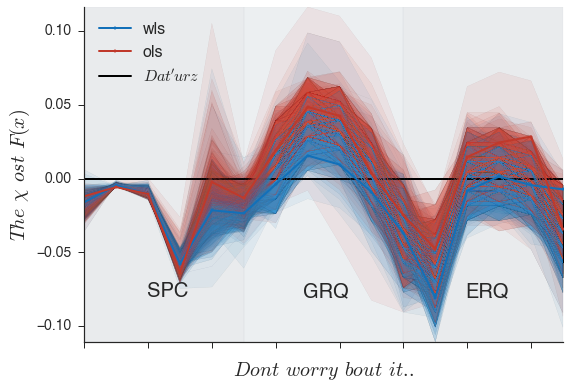

In [5]:
devtests.compare_ols_wls_predictions(data, ip, maxfun=1000, ntrials=5000, save=True)

In [355]:
report_fit(p)
report_fit(popt)

[[Variables]]
    a:       0.45967252 (init= 0.4440941)
    ssv:    -1.05416919 (init=-0.9473393)
    v:       1.18713039 (init= 1.290714)
    zperc:   0.34209432 (init= 0.3473285)
    tr:      0.30665190 (init= 0.3048707)
    z:       0.15725136  == 'zperc*a'
[[Correlations]] (unreported correlations are <  0.100)
[[Fit Statistics]]
    # function evals   = 71
    # data points      = 16
    # variables        = 5
    chi-square         = 0.023342075
    reduced chi-square = 0.002
[[Variables]]
    a:       0.45967252 (init= 0.4440941)
    ssv:    -1.05416919 (init=-0.9473393)
    v:       1.18713039 (init= 1.290714)
    zperc:   0.34209432 (init= 0.3473285)
    tr:      0.30665190 (init= 0.3048707)
    z:       0.15725136  == 'zperc*a'
[[Correlations]] (unreported correlations are <  0.100)


In [365]:
sd = m.observed.groupby(m.cond).std()

pc = m.data.query('trial_type=="go"').groupby(m.cond).response.mean().values
pe = m.data.query('trial_type=="stop"').groupby(m.cond).response.mean().values

sdc = sd.loc[:,'c5':'c95'].values
sde = sd.loc[:,'e5':'e95'].values

lbls = m.data[m.cond].unique()

wtc = np.array([p*(s.min()/s) for p, s in zip(pc, sdc)])
wte = np.array([p*(s.min()/s) for p, s in zip(pe, sde)])

In [383]:
sdc[0].min()/sdc[0]


array([ 0.90293322,  1.        ,  0.90850019,  0.88396654,  0.84966831])

In [316]:
inits = ip.copy()
inits['v']=ip['v']+.15*ip['v']
m = build.Model(data=data, inits=inits, depends_on={'v':'Cond'}, fit='subjects')
m.prepare_fit()


wts = m.wts['bsl']
#wts=np.ones_like(wts)
y = m.observed.query('Cond=="bsl"').mean().iloc[1:].values



ntrials=10000
maxfun=500
ftol=1.e-2
xtol=1.e-2
all_params=1
disp=True

lim = {'tr': (.001, .5), 'v': (.01, 4.),  'ssv': (-4., -.01),  'a' : (.01, .6)}


if 'pGo' in inits.keys(): del inits['pGo']
if 'ssd' in inits.keys(): del inits['ssd']

p=Parameters()

if all_params:
      p.add('a', value=inits['a'], vary=1, min=lim['a'][0], max=lim['a'][1])
      p.add('ssv', value=inits['ssv'], vary=1, min=lim['ssv'][0], max=lim['ssv'][1])
      p.add('v', value=inits['v'], vary=1, min=lim['v'][0], max=lim['v'][1])
      p.add('zperc', value=inits['z']/inits['a'], vary=1, min=.01, max=.99)
      p.add('tr', value=inits['tr'], vary=1, min=lim['tr'][0], max=lim['tr'][1])
      p.add('z', expr="zperc*a")
else:
      for key, val in inits.items():
            if key in depends:
                  p.add(key, value=val, vary=1, min=lim[key][0], max=lim[key][1])
                  continue
            p.add(key, value=val, vary=0)

preparing reactive model using subjects method


In [335]:
p.valuesdict()

OrderedDict([('a', 0.45967252595505481), ('ssv', -1.0541691978141601), ('v', 1.1871303949690408), ('zperc', 0.34209432472573892), ('tr', 0.30665190552312055), ('z', 0.15725136236156917)])

In [ ]:
collect=wls_update

popt = Minimizer(recost_nb, p, fcn_args=(y, ntrials), fcn_kws={'wts':wts, 'collect':collect}, method='Nelder-Mead')
popt.fmin(maxfun=maxfun, ftol=ftol, xtol=xtol, full_output=True, disp=disp)
params={k: p[k].value for k in p.keys()}
params['chi']=popt.chisqr
resid=popt.residual; yhat=y+resid

In [320]:
len(ols_update)

79

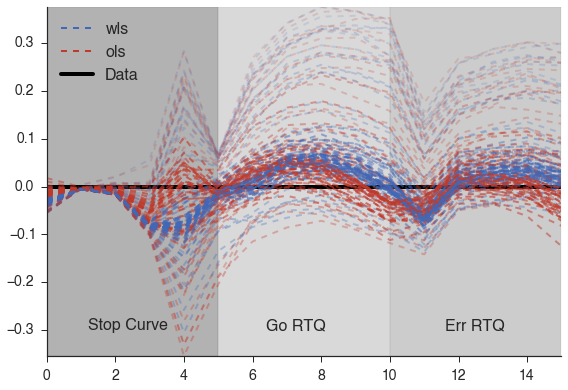

In [356]:
sns.set_context('notebook', font_scale=1.4)
htmin, htmax = [], []

nsims=np.min([len(ols_update), len(wls_update)])
alpha = np.linspace(.15,.75, nsims)

for i in range(nsims):
      
      wres = y-wls_update[i]
      ores = y-ols_update[i]
      
      plt.plot(wres, color='#4168B7', alpha=alpha[i], linestyle='--', lw=2)
      plt.plot(ores, color='#c0392b', alpha=alpha[i], linestyle='--', lw=2)
      
      htmin.append(np.hstack([ores, wres]).min())
      htmax.append(np.hstack([ores, wres]).max())


plt.plot(np.arange(10,20,10), label='wls', color='#4168B7', alpha=1, linestyle='--', lw=2)
plt.plot(np.arange(10,20,10), label='ols', color='#c0392b', alpha=1, linestyle='--', lw=2)

ht = np.array([np.min(htmin), np.max(htmax)])      
plt.fill_betweenx(ht, x1=0, x2=5, color='k', alpha=.3)
plt.fill_betweenx(ht, x1=5, x2=10, color='k', alpha=.15)
plt.fill_betweenx(ht, x1=10, x2=15, color='k', alpha=.2)
plt.hlines(y=0, xmin=0, xmax=15, color='k', linestyle='-', lw=4, label='Data')
plt.setp(plt.gca(), xlim=(0,15), ylim=(ht[0], ht[1]))
sns.despine()      
plt.legend(loc=0, fontsize=16)
ax = plt.gca()
ax.text(1.2, -.3, 'Stop Curve', fontsize=16)
ax.text(6.4, -.3, 'Go RTQ', fontsize=16)
ax.text(11.6, -.3, 'Err RTQ', fontsize=16)
plt.tight_layout()
plt.savefig('/home/kyle/Dropbox/track_optimizer_rebsl.png', dpi=600)

In [344]:
popt.

In [314]:
def recost_nb(theta, y=None, ntrials=2000, wts=None, pGo=.5, fit=True, collect=None, ssd=np.arange(.2, .45, .05)):

      if not type(theta)==dict:
            #pu = theta.copy()
            theta = theta.valuesdict()
            #iter_update.append(pu.valuesdict())

      a, tr, v, ssv, z  = theta['a'], theta['tr'], theta['v'], -abs(theta['ssv']),  theta['z']
      #if 'zperc' in theta.keys():
            

      nss = int((1-pGo)*ntrials)
      dvg, dvs = cRADD.run(a, tr, v, ssv, z, ssd, nss=nss, ntot=ntrials)
      yhat = cRADD.analyze_reactive(dvg, dvs, a, tr, ssd, nss=nss)
      #ols_update.append(yhat)
      if collect==[]:
            collect.append(yhat)
            
      wtc, wte = wts[0], wts[1]
      cost = np.hstack([y[:6]-yhat[:6], wtc*y[6:11]-wtc*yhat[6:11], wte*y[11:]-wte*yhat[11:]]).astype(np.float32)
      
      
      if collect==[]:
            collect.append(yhat)
            
      return cost


array([ 0.9268595 ,  0.98830485,  0.97303247,  0.86013103,  0.53338009,
        0.13202624,  5.12819576,  5.47817516,  5.67953157,  5.85847759,
        6.10287666,  4.94813681,  5.28328943,  5.50362492,  5.68832922,
        5.95608377], dtype=float32)

In [159]:
popt.values

{'a': 0.44469733069229772,
 'ssv': -0.95641363603405694,
 'tr': 0.30564869699698249,
 'v': 1.1000045565918406,
 'z': 0.15362025100803273,
 'zperc': 0.34544900633624037}

In [121]:
def recost_nb(theta, y, ntrials=2000, wts=None, pGo=.5, ssd=np.arange(.2, .45, .05)):

      if not type(theta)==dict:
            theta = theta.valuesdict()

      a, tr, v, ssv, z  = theta['a'], theta['tr'], theta['v'], -abs(theta['ssv']),  theta['z']

      nss = int((1-pGo)*ntrials)
      dvg, dvs = cRADD.run(a, tr, v, ssv, z, ssd, nss=nss, ntot=ntrials)
      yhat = cRADD.analyze_reactive(dvg, dvs, a, tr, ssd, nss=nss)

      if wts is None:
            cost = (y-yhat).astype(np.float32)
      else:
            wtc, wte = wts[0], wts[1]
            cost = np.hstack([y[:6]-yhat[:6], wtc*y[6:11]-wtc*yhat[6:11], wte*y[11:]-wte*yhat[11:]]).astype(np.float32)

      return cost


In [270]:
#popt = Minimizer(recost, p, fcn_args=(y, ntrials), method='Nelder-Mead')
a, tr, v, ssv, z  = theta['a'], theta['tr'], theta['v'], -abs(theta['ssv']),  theta['z']
x0=[a, tr, v, ssv, z]
fit = mina(recost_nb, p, args=(y, wts, ntrials), method='Nelder-Mead', options={'disp':True, 'xtol':xtol, 'ftol':ftol, 'maxfev': 10})
#popt.fmin(maxfun=50, ftol=ftol, xtol=xtol, full_output=True, disp=disp)

In [268]:
def recost_scipy(p, y=None, wts=None, ntrials=2000, pGo=.5, ssd=np.arange(.2, .45, .05)):

      a, tr, v, ssv, z  = p[0], p[1], p[2], p[3], p[4]
      
      nss = int((1-pGo)*ntrials)
      dvg, dvs = cRADD.run(a, tr, v, ssv, z, ssd, nss=nss, ntot=ntrials)
      yhat = cRADD.analyze_reactive(dvg, dvs, a, tr, ssd, nss=nss)

      if wts is None:
            cost=np.sum((y[0]-yhat[0])**2+(y[1:6]-yhat[1:6])**2+(y[6:11]-yhat[6:11])**2+(y[11:]-yhat[11:])**2)
      else:
            wtgc, wtsc, wtgq, wteq = wts[0], wts[1], wts[2], wts[3]
            cost = np.sum((wtgc*(y[0]-yhat[0]))**2+(wtsc*(y[1:6]-yhat[1:6]))**2 +(wtgq*(y[6:11]-yhat[6:11]))**2+(wteq*(y[11:]-yhat[11:]))**2)

      return cost

In [327]:
def recost(theta, y, ntrials=2000, wts=None, pGo=.5, ssd=np.arange(.2, .45, .05)):

      if not type(theta)==dict:
            theta = theta.valuesdict()#theta={k:theta[k].value for k in theta.keys()}

      a, tr, v, ssv, z  = theta['a'], theta['tr'], theta['v'], -abs(theta['ssv']),  theta['z']

      nss = int((1-pGo)*ntrials)
      dvg, dvs = cRADD.run(a, tr, v, ssv, z, ssd, nss=nss, ntot=ntrials)
      yhat = cRADD.analyze_reactive(dvg, dvs, a, tr, ssd, nss=nss)

      if wts is None:
            cost = (y-yhat).astype(np.float32)
            #wtcost = cost[0]*wts[0], 
      else:
            wta, wtc, wte = wts[0], wts[1], wts[2]
            cost = np.hstack([(y[:6]-yhat[:6]), wtc*(y[6:11]-yhat[6:11]), wte*(y[11:]-yhat[11:])]).astype(np.float32)

      return cost


In [287]:
wtgc, wtsc, wtgq, wteq = wts[0], wts[1], wts[2], wts[3]

In [313]:
wtsc

array([ 1.        ,  0.58127298,  0.20726457,  0.09479225,  0.15052034])

In [330]:
recost(p, y=y, wts=wts)

array([ 0.051     ,  0.        ,  0.019     ,  0.067     ,  0.17299998,
       -0.108     ,  0.2379507 ,  0.10293853, -0.00361048, -0.10081801,
       -0.19396181,  0.11379961,  0.07911323,  0.01262239, -0.06497709,
        0.0200608 ], dtype=float32)

array([ 1.        ,  1.        ,  1.        ,  1.        ,  0.64999998,
        0.        ,  5.31652832,  5.45151615,  5.58496714,  5.71775961,
        5.9846158 ,  5.05237722,  5.31769085,  5.45120001,  5.58360052,
        5.96863842], dtype=float32)